#Color Detection Sytem

In [ ]:
import math
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import Dataset, random_split
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Hyperparameters
batch_size = 64
num_iters = 30000
num_hidden = 32 
learning_rate = 0.0001

input_dim = 1*3
output_dim = 11

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Dataset Design

In [ ]:
path = '/content/drive/MyDrive/Color Detection(SC Project)/color_dataset.csv'
df = pd.read_csv(path)
color_data = pd.read_csv(path)
color_data.label = pd.Categorical(pd.factorize(color_data.label)[0])

In [ ]:
label_dict = {}
label_dict = pd.Series(df.label.values,index=color_data.label).to_dict()
print(label_dict)

{0: 'Blue', 1: 'Brown', 2: 'Green', 3: 'Pink', 4: 'Yellow', 5: 'Orange', 6: 'Purple', 7: 'Red', 8: 'Grey', 9: 'White', 10: 'Black'}


In [ ]:
class ColorDataset(Dataset):

    def __init__(self, df):

      x = df.iloc[:, 0:3].values
      y = df.iloc[:, 3].values
      
      sc = StandardScaler()
      x_data = sc.fit_transform(x)
      y_data = y

      self.x_data = torch.tensor(x_data, dtype=torch.float32)
      self.y_data = torch.tensor(y_data)

    def __len__(self):
        return len(self.y_data)
    
    def __getitem__(self, idx):            
        return self.x_data[idx], self.y_data[idx]

all_data = ColorDataset(color_data)
print(len(all_data))

5052


In [ ]:
length = len(all_data)
train_len = math.ceil(length * 0.8)
test_len = math.floor(length * 0.2)
train_dataset, test_dataset = random_split(all_data, (train_len, test_len))

In [ ]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=2, 
                                          shuffle=False)  

#Neural Network Design

In [ ]:
class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()

        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, 24)
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(24, 24)
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(24, 24)
        self.relu_3 = nn.ReLU()

        ### 4th hidden layer: 100 --> 100
        self.linear_4 = nn.Linear(24, 16)
        self.relu_4 = nn.ReLU()

        ### Output layer: 100 --> 11
        self.linear_out = nn.Linear(16, num_classes)

    def forward(self, x):

        ### 1st hidden layer
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        out = self.relu_4(out)

        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = NeuralNetworkModel(input_size = input_dim,
                           num_classes = output_dim,
                           num_hidden = num_hidden)
# To enable GPU
model.to(device)

NeuralNetworkModel(
  (linear_1): Linear(in_features=3, out_features=24, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=24, out_features=24, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=24, out_features=24, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=24, out_features=16, bias=True)
  (relu_4): ReLU()
  (linear_out): Linear(in_features=16, out_features=11, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from sklearn.metrics import confusion_matrix

iter = 0
loss_data = []
accuracy_data = []

nb_classes = 11
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(train_loader):

        features = features.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(features) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for features, labels in test_loader:
               
                features = features.to(device)
                labels = labels.to(device)
                print("Feature")
                print(features)
                # Forward pass only to get logits/output
                outputs = model(features)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
                # Append batch prediction results
                predlist=torch.cat([predlist,predicted.view(-1).cpu()])
                lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            loss_data.append(loss.item())
            accuracy_data.append(accuracy)
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

# Loss and Accuracy Graph

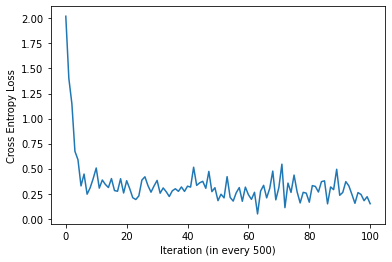

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(loss_data)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

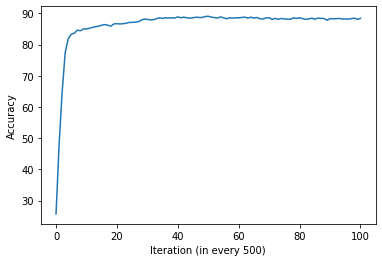

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(accuracy_data)
plt.ylabel('Accuracy')
plt.xlabel('Iteration (in every 500)')
plt.show()

# Prediction

In [ ]:
for features, labels in test_loader:
  break
predictions = model.forward(features.to(device))
predictions = torch.argmax(predictions, dim=1)
print(labels)
print('Predicted labels', predictions.cpu().numpy())

tensor([2, 4])
Predicted labels [2 4]


In [ ]:
RGB = []
#red = int(input("Red Value:"))
#green = int(input("Green Value:"))
#blue = int(input("Blue Value:"))
red = 255
green = 0
blue = 0

print("RGB Value: " + str(red) + ", " + str(green) + ", " + str(blue))


RGB Value: 255, 0, 0


In [ ]:
from pandas import DataFrame
People_List = [[red,green,blue,0],[0,0,0,0]]

df = DataFrame (People_List, columns=['red','green','blue','label'])
input_data = ColorDataset(df)

In [ ]:
for features, labels in input_data:
  predictions = model.forward(features.to(device))
  predictions = torch.argmax(predictions)
  a = predictions.cpu().numpy()
  print(list(label_dict.values())[list(label_dict.keys()).index(a[()])])

Red
Blue


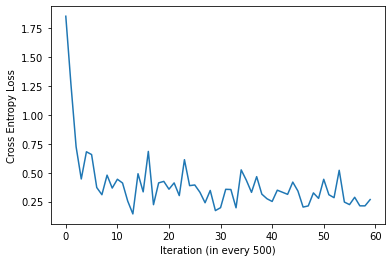

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(loss_data)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

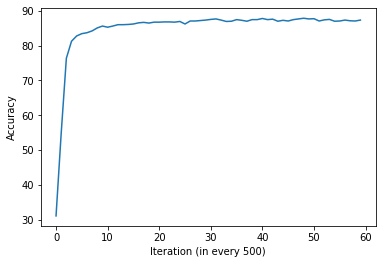

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(accuracy_data)
plt.ylabel('Accuracy')
plt.xlabel('Iteration (in every 500)')
plt.show()